# Oblig2:
___
- Student Number: S374918
- Student Name: Alex McCorkle

(Lecturer said it was OK to do it alone)

___
## Algorithm Selection

For this assignment, I chose the use case of predicting stock prices. This is a regression problem because we aim to predict a continuous value (the stock price) based on historical data.

After researching various algorithms, I decided to use the Gradient Boosting Regressor. This algorithm is effective for regression tasks and is known for its accuracy and ability to handle complex datasets. It creates an ensemble of weak prediction models, usually decision trees, and optimizes them to minimize the loss function.

In [415]:
# Imports:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error # VSCode thinks this is deprecated and to use root_mean_squared_error but in the AI env this should work
from datetime import datetime as dt
from sklearn.ensemble import GradientBoostingRegressor


# reading the data:
df = pd.read_csv('TSLA.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [416]:
# Since we are going to predict the stock price for a given date, we are mainly interested in 'Date' and 'Close'
# So we can drop the rest so it's a little more organized

df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

df.tail()

,Date,Close
2840,2021-10-08,785.489990
2841,2021-10-11,791.940002
2842,2021-10-12,805.719971
2843,2021-10-13,811.080017
2844,2021-10-14,818.320007


___
## Data Preparation
We start by loading and preprocessing the data:

In [417]:
# Since Date is a String, we need to convert it to Datetime to be able to manipulate and use the data
df['Date'] = pd.to_datetime(df['Date'])



# We can then seperate the date into multiple columns:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek # monday = 0, Sunday = 6

cols=list(df.columns.values)
cols.pop(cols.index('Close'))
df = df[cols + ['Close']]

df.set_index('Date', inplace=True)

df.head()

,Year,Month,Day,DayOfWeek,Close
Date,,,,,
2010-06-29,2010,6,29,1,4.778
2010-06-30,2010,6,30,2,4.766
2010-07-01,2010,7,1,3,4.392
2010-07-02,2010,7,2,4,3.840
2010-07-06,2010,7,6,1,3.222


___
## Data Visualization
Let's visualize our data to better understand the trends:

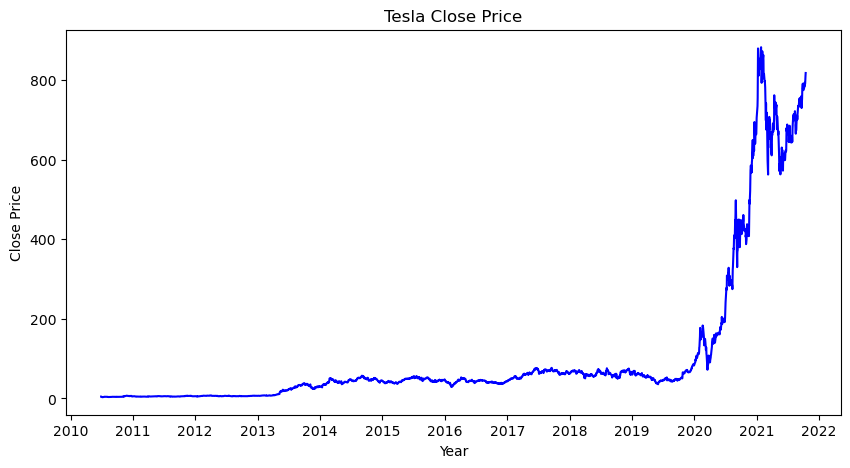

In [418]:
def plot_close(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Close'], color='blue')
    plt.title('Tesla Close Price')
    plt.xlabel('Year')
    plt.ylabel('Close Price')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.show()

plot_close(df)

___
Since the stock after 2019 is nowhere near 0 as opposed to 2019 and earlier, it might be worth cutting out any data from this time period cause this might lead to poor predictions as these low values will weigh heavily (assuming Tesla doesn't go bankrupt)

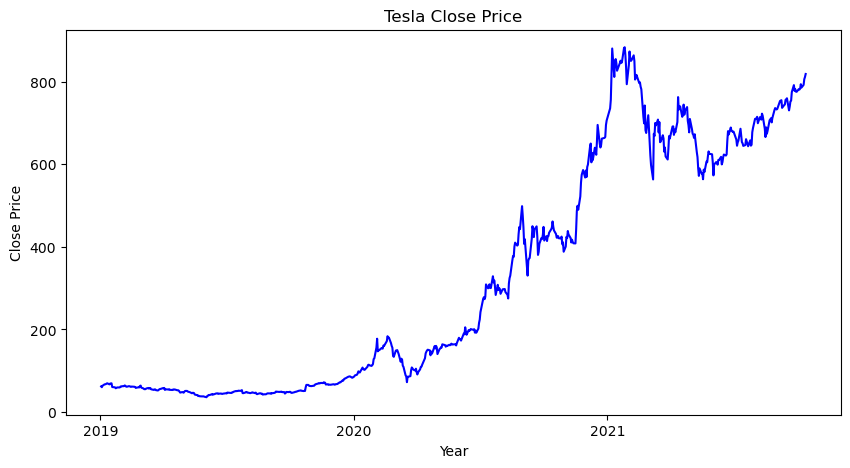

In [419]:
# So let's take 2019 onwards:
df = df[df.index >= '2019-01-01']

plot_close(df)

In [420]:
# Making sure we aren't missing any values
df.isna().sum()

Year         0
Month        0
Day          0
DayOfWeek    0
Close        0
dtype: int64

___
## Model Training
Now we'll split our data, train our Gradient Boosting Regressor, and evaluate its performance:

In [421]:
# Seperate features and target:

X = df.drop(['Close'], axis=1)
y = df['Close']

# Split the data: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


GradientBoostingRegressor()

___
## Evaluating the Model:

In [422]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) # Compares the test value with the predicted to see how far off it is
r2 = r2_score(y_test, y_pred) # Shows the accuracy, 0 = bad, 1 = bueno
print(f"MSE = {mse}")
print(f"R-Squared Score = {r2}")

MSE = 621.1035171297331
R-Squared Score = 0.9922058872370091


We see that although the R-Squared Score is very close to 1 (A good thing), that the MSE is quite high. If we were to make the model a bit more advanced we might have to fine-tune the model a bit more to reduce this MSE. 

___
## Model Performance Visualization
Let's visualize how well the model predicts compared to the actual prices:

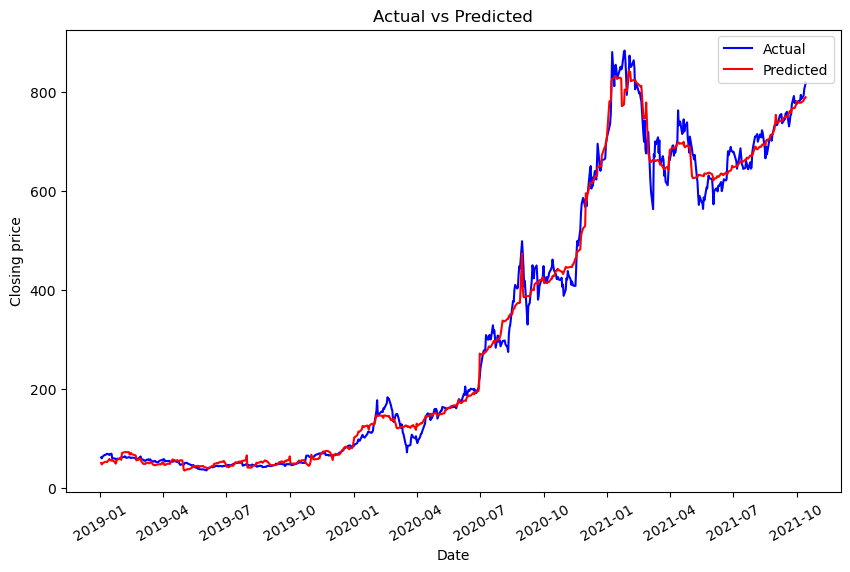

In [423]:
def plot_predictions(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, actual, color='blue', label='Actual')
    plt.plot(df.index, predicted, color='red', label='Predicted')
    plt.xlabel('Date')
    plt.legend()
    # Rotate
    plt.xticks(rotation=30)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.ylabel('Closing price')
    plt.title('Actual vs Predicted')
    plt.show()

predicted = model.predict(X)
plot_predictions(y, predicted)

___
## Price Prediction Function
Now to create a function that can predict the stock price for any given date:

In [424]:
def predict_price(date):
  # Create a temporary df with the input date
  temp = pd.DataFrame({'Date': [date]})

  # Convert 'Date' to datetime
  temp['Date'] = pd.to_datetime(temp['Date'])

  # Seperate Year, Month, Day, DayOfWeek
  temp['Year'] = temp['Date'].dt.year
  temp['Month'] = temp['Date'].dt.month
  temp['Day'] = temp['Date'].dt.day
  temp['DayOfWeek'] = temp['Date'].dt.dayofweek

  # Prepare the input data for prediction
  X = temp.drop(['Date'], axis=1)

  # Make the prediction
  predicted_price = model.predict(X)

  return predicted_price[0]

# CHANGE THIS VALUE TO TEST FUNCTION: (YYYY-MM-DD)
predict_date = '2020-02-05'


print(f"The predicted price for {predict_date} is {predict_price(predict_date)}")




The predicted price for 2020-02-05 is 146.016199254966


___
## Conclusion/Future Improvements:

The model has shown that it can relatively accurately predict Stock Price. However, the MSE is quite high and this is something that could be improved on with a bit of extra functionality. Some things we could do to expand this further could be:
1. Feature Engineering:
  - We could expand the features beyond just date-related features. We could for example adjust for Holidays etc. or days that might be outliers in terms of trading. 
2. Use more up-to-date Data:
  - The data file provided only has data up until 2021, and most of the data prior to 2019 was quite close to 0. More data from the years 2022-2024 would probably improve the model as it would have more data to be trained on.
3. Try different ML algorithms:
  - I could of course, try a different ML algorithm to see if it performs better. We could try Random Forest Regressor for example. 